# Tutorial of implementing Batch normalization and Drop out
fashion mnist image를 분류하는 Convolution Neural Network에 Batch normalization과 Drop out을 동시 적용하는 간단한 example

### Setup

In [1]:
import os, sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pylab as plt
from keras.datasets import fashion_mnist
%matplotlib inline

Using TensorFlow backend.


### Load Fashion-mnist dataset

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

### Split Fashion-mnist dataset

In [3]:
label_set = {0 : 'T-shirt/top', 1 : 'Trouser', 2 : 'Pullover',
             3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
             7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle boot'}
label_set

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

In [4]:
x_val = x_train[55000:].reshape(-1,28,28,1)
y_val = y_train[55000:]
x_train = x_train[:55000].reshape(-1,28,28,1)
y_train = y_train[:55000]   
x_test = x_test.reshape(-1,28,28,1)

In [5]:
with tf.Session() as sess:
    y_val, y_train, y_test = sess.run([tf.one_hot(y_val, depth = 10), tf.one_hot(y_train, depth = 10), tf.one_hot(y_test, depth = 10)])

Text(0.5,1,'Ankle boot')

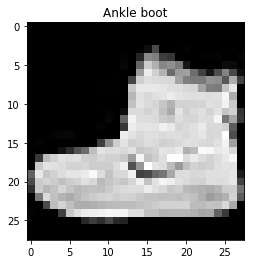

In [6]:
plt.imshow(x_train[0].reshape(28, 28), cmap = 'gray')
plt.title(label_set.get(np.argmax(y_train[0])))

### Define FashionCNN class

In [7]:
## dropout, batch_normalization, he_initialization,....
class FashionCNN:
    def __init__(self, activation_fn = tf.nn.relu,
                 initializer = tf.contrib.layers.variance_scaling_initializer(), l2_scale = 0.01):
        
        with tf.variable_scope('input_layer'):
            self._x = tf.placeholder(dtype = tf.float32, shape = [None,28,28,1])
            self._y = tf.placeholder(dtype = tf.float32, shape = [None, 10])
            self._training = tf.placeholder(dtype = tf.bool) # batch normalization 
            self._keep_prob = tf.placeholder(dtype = tf.float32) # dropout의 keep_prob
            
        with tf.variable_scope('conv_layer1'):
            _conv_pre= tf.layers.conv2d(inputs = self._x, filters = 64, kernel_size = [3,3],
                                        padding = 'same', kernel_initializer = initializer,
                                        kernel_regularizer = tf.contrib.layers.l2_regularizer(scale = l2_scale))
            _conv_bn = tf.layers.batch_normalization(inputs = _conv_pre, momentum = .9, training = self._training)
            _conv_ac = activation_fn(_conv_bn)
            
        with tf.variable_scope('conv_layer2'):
            _conv_pre= tf.layers.conv2d(inputs = _conv_ac, filters = 64, kernel_size = [3,3],
                                        padding = 'same', kernel_initializer = initializer,
                                        kernel_regularizer = tf.contrib.layers.l2_regularizer(scale = l2_scale))
            _conv_bn = tf.layers.batch_normalization(inputs = _conv_pre, momentum = .9, training = self._training)
            _conv_ac = activation_fn(_conv_bn)
            
        with tf.variable_scope('max_pool1'):
            _pooled = tf.layers.max_pooling2d(inputs = _conv_ac, pool_size = [2,2], strides = 2)            

        with tf.variable_scope('conv_layer3'):
            _conv_pre= tf.layers.conv2d(inputs = _pooled, filters = 128, kernel_size = [3,3],
                                        padding = 'same', kernel_initializer = initializer,
                                        kernel_regularizer = tf.contrib.layers.l2_regularizer(scale = l2_scale))
            _conv_bn = tf.layers.batch_normalization(inputs = _conv_pre, momentum = .9, training = self._training)
            _conv_ac = activation_fn(_conv_bn)
            
        with tf.variable_scope('conv_layer4'):
            _conv_pre= tf.layers.conv2d(inputs = _conv_ac, filters = 128, kernel_size = [3,3],
                                        padding = 'same', kernel_initializer = initializer,
                                        kernel_regularizer = tf.contrib.layers.l2_regularizer(scale = l2_scale))
            _conv_bn = tf.layers.batch_normalization(inputs = _conv_pre, momentum = .9, training = self._training)
            _conv_ac = activation_fn(_conv_bn)

        with tf.variable_scope('max_pool2'):
            _pooled = tf.layers.max_pooling2d(inputs = _conv_ac, pool_size = [2,2], strides = 2)
 
            
        with tf.variable_scope('conv_layer5'):
            _conv_pre= tf.layers.conv2d(inputs = _pooled, filters = 256, kernel_size = [3,3],
                                        padding = 'same', kernel_initializer = initializer,
                                        kernel_regularizer = tf.contrib.layers.l2_regularizer(scale = l2_scale))
            _conv_bn = tf.layers.batch_normalization(inputs = _conv_pre, momentum = .9, training = self._training)
            _conv_ac = activation_fn(_conv_bn)

        with tf.variable_scope('conv_layer6'):
            _conv_pre= tf.layers.conv2d(inputs = _conv_ac, filters = 256, kernel_size = [3,3],
                                        padding = 'same', kernel_initializer = initializer,
                                        kernel_regularizer = tf.contrib.layers.l2_regularizer(scale = l2_scale))
            _conv_bn = tf.layers.batch_normalization(inputs = _conv_pre, momentum = .9, training = self._training)
            _conv_ac = activation_fn(_conv_bn)

            
        with tf.variable_scope('max_pool3'):
            _pooled = tf.layers.max_pooling2d(inputs = _conv_ac, pool_size = [2,2], strides = 2)

        with tf.variable_scope('dense_layer1'):
            _pooled_vector = tf.reshape(tensor = _pooled, shape = [-1,np.cumprod(_pooled.get_shape().as_list()[-3:])[-1]])
            _fc_pre = tf.layers.dense(inputs = _pooled_vector, units = 100, kernel_initializer = initializer,
                                      kernel_regularizer = tf.contrib.layers.l2_regularizer(scale = l2_scale))
            _fc_bn = tf.layers.batch_normalization(inputs = _fc_pre, momentum = .9, training = self._training)
            _fc_ac = activation_fn(_fc_bn)
            
        with tf.variable_scope('dense_layer2'):
            _fc_pre = tf.layers.dense(inputs = _fc_ac, units = 100, kernel_initializer = initializer,
                                      kernel_regularizer = tf.contrib.layers.l2_regularizer(scale = l2_scale))
            _fc_bn = tf.layers.batch_normalization(inputs = _fc_pre, momentum = .9, training = self._training)
            _fc_ac = activation_fn(_fc_bn)
            _fc_ac = tf.nn.dropout(x = _fc_ac, keep_prob = self._keep_prob)

        with tf.variable_scope('output_layer'):
            self._score = tf.layers.dense(inputs = _fc_ac, units = 10, kernel_initializer = initializer,
                                      kernel_regularizer = tf.contrib.layers.l2_regularizer(scale = l2_scale))
        
        with tf.variable_scope('loss'):
            _ce_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = self._y, logits = self._score))
            _reg_term = tf.reduce_sum(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))
            self._total_loss = _ce_loss +  _reg_term
        # 객체변수에 model class 코드로 생성되는 graph의 UPDATE_OPS를 저장
        self._update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS) 
        
        with tf.variable_scope('predict'):
            self._prediction = tf.argmax(input = self._score, axis = 1)
    
    def predict(self, sess, x_data, training = False, keep_prob = 1.):
        feed_predict = {self._x : x_data, self._training : training, self._keep_prob : keep_prob}
        return sess.run(fetches = self._prediction, feed_dict = feed_predict)       

### Define Solver class

In [8]:
class Solver:
    def __init__(self, model, optimizer = tf.train.AdamOptimizer, var_list = None):
        self._model = model
        self._lr = tf.placeholder(dtype = tf.float32)
        self._optimizer = optimizer(learning_rate = self._lr)
        
        # Solver class는 model class로부터 생성된 instance를 input으로 받음. model class에서 저장한 객체변수를 아래와 같이 활용
        with tf.control_dependencies(self._model._update_ops):
            self._training_op = self._optimizer.minimize(loss = self._model._total_loss, var_list = var_list)
    
    def train(self, sess, x_data, y_data, lr, training = True, keep_prob = .5):
        feed_train = {self._model._x : x_data, self._model._y : y_data, self._lr : lr,
                      self._model._training : training, self._model._keep_prob : keep_prob}
        return sess.run(fetches = [self._training_op, self._model._total_loss], feed_dict = feed_train)
            
    def evaluate(self, sess, x_data, y_data, training = False, keep_prob = 1.):
        feed_loss = {self._model._x : x_data, self._model._y : y_data, self._model._training : training,
                     self._model._keep_prob : keep_prob}
        return sess.run(fetches = self._model._total_loss, feed_dict = feed_loss)

### Generate CNN model and Solvers

In [9]:
sess = tf.Session()
fashion_classifier = FashionCNN()

In [10]:
adam_solver = Solver(model = fashion_classifier)
sgd_solver = Solver(model = fashion_classifier, optimizer = tf.train.GradientDescentOptimizer)

### Training

In [11]:
# Hyper-parameters
batch_size = 100
n_epochs = 10
tr_loss_history = []
val_loss_history = []

In [12]:
sess.run(tf.global_variables_initializer())

In [13]:
for epoch in range(n_epochs):
    avg_tr_loss = 0
    avg_val_loss = 0
    total_batch = int(x_train.shape[0] / batch_size)
    
    if epoch  <= 8:
        
        for step in range(total_batch):
            tr_indices = np.random.choice(np.arange(x_train.shape[0]), size = batch_size, replace=False)
            val_indices = np.random.choice(np.arange(x_val.shape[0]), size = batch_size, replace=False)
            batch_xs = x_train[tr_indices]
            batch_ys = y_train[tr_indices]
            val_xs = x_val[val_indices]
            val_ys = y_val[val_indices]
            _, tr_loss = adam_solver.train(sess = sess, x_data = batch_xs, y_data = batch_ys, lr = 1e-3)
            val_loss = adam_solver.evaluate(sess = sess, x_data = val_xs, y_data = val_ys)

            avg_tr_loss += tr_loss / total_batch
            avg_val_loss += val_loss / total_batch
            if step % 100 == 0:
                print('step : {:3}, tr_loss : {:.3f}, val_loss : {:.3f}'.format(step, tr_loss, val_loss))

        print('epoch : {:3}, tr_loss : {:.3f}, val_loss : {:.3f}'.format(epoch, avg_tr_loss, avg_val_loss))
        tr_loss_history.append(avg_tr_loss)
        val_loss_history.append(avg_val_loss)
        
    else :

        for step in range(total_batch):
            tr_indices = np.random.choice(np.arange(x_train.shape[0]), size = batch_size, replace=False)
            val_indices = np.random.choice(np.arange(x_val.shape[0]), size = batch_size, replace=False)
            batch_xs = x_train[tr_indices]
            batch_ys = y_train[tr_indices]
            val_xs = x_val[val_indices]
            val_ys = y_val[val_indices]
            _, tr_loss = sgd_solver.train(sess = sess, x_data = batch_xs, y_data = batch_ys, lr = 1e-3)
            val_loss = sgd_solver.evaluate(sess = sess, x_data = val_xs, y_data = val_ys)

            avg_tr_loss += tr_loss / total_batch
            avg_val_loss += val_loss / total_batch
            if step % 100 == 0:
                print('step : {:3}, tr_loss : {:.3f}, val_loss : {:.3f}'.format(step, tr_loss, val_loss))

        print('epoch : {:3}, tr_loss : {:.3f}, val_loss : {:.3f}'.format(epoch, avg_tr_loss, avg_val_loss))
        tr_loss_history.append(avg_tr_loss)
        val_loss_history.append(avg_val_loss)

step :   0, tr_loss : 14.564, val_loss : 25.993
step : 100, tr_loss : 7.631, val_loss : 7.673
step : 200, tr_loss : 4.336, val_loss : 4.407
step : 300, tr_loss : 2.605, val_loss : 2.760
step : 400, tr_loss : 1.701, val_loss : 1.746
step : 500, tr_loss : 1.328, val_loss : 1.836
epoch :   0, tr_loss : 4.327, val_loss : 4.411
step :   0, tr_loss : 1.149, val_loss : 1.328
step : 100, tr_loss : 1.013, val_loss : 0.995
step : 200, tr_loss : 1.025, val_loss : 1.058
step : 300, tr_loss : 0.771, val_loss : 0.871
step : 400, tr_loss : 0.857, val_loss : 0.885
step : 500, tr_loss : 0.841, val_loss : 0.906
epoch :   1, tr_loss : 0.917, val_loss : 0.945
step :   0, tr_loss : 0.695, val_loss : 0.813
step : 100, tr_loss : 0.837, val_loss : 0.684
step : 200, tr_loss : 0.664, val_loss : 0.900
step : 300, tr_loss : 0.562, val_loss : 0.809
step : 400, tr_loss : 0.663, val_loss : 0.817
step : 500, tr_loss : 0.832, val_loss : 0.824
epoch :   2, tr_loss : 0.738, val_loss : 0.783
step :   0, tr_loss : 0.688, 

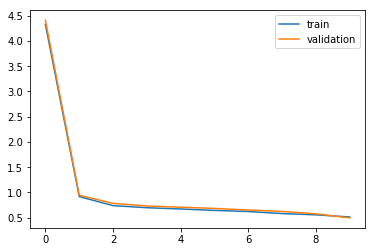

In [14]:
plt.plot(tr_loss_history, label = 'train')
plt.plot(val_loss_history, label = 'validation')
plt.legend()

In [15]:
hat = fashion_classifier.predict(sess=sess, x_data = x_test)

In [16]:
print('accuracy : {:.2%}'.format(np.mean(np.argmax(y_test, axis = 1) == hat)))

accuracy : 91.16%
